<a href="https://colab.research.google.com/github/ErickPol0/PortfolioProject/blob/main/segmentacion_de_clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentación de clientes
*Erick Polo -190300372*

#Introduccion y exploracion de datos

El objetivo de esta practica es de crear grupos de clientes, segmentandolos a partir de atributos que estos tienen. A fin de poder optimizar estrategias de venta. Para esta practica, de aprendizaje no supervisado, se emplea un modelo de k-medias, pero no sin antes explorar un poco los datos, limpiarlos y transformarlos. Al final se logra un perfilado de segmentos y se describen un poco.

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from matplotlib import pyplot as plt
from numpy.lib.function_base import blackman
import random

In [ ]:
df = pd.read_csv('customer_data_sub.csv',delimiter=";")
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,462809,Male,No,22,No,Healthcare,10.0,Low,40.0
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,30.0
2,466315,Female,Yes,67,Yes,Engineer,10.0,Low,10.0
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,20.0
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,60.0


**Exploracion**

Primero revisamos aquellos valores unicos de las variables categoricas, para saber que podemos esperar.

In [ ]:
print("Gender",df.Gender.unique())
print("Ever_Married",df.Ever_Married.unique())
print("Graduated",df.Graduated.unique())
print("Profession",df.Profession.unique())
print("Spending_Score",df.Spending_Score.unique())

Gender ['Male' 'Female']
Ever_Married ['No' 'Yes' nan]
Graduated ['No' 'Yes' nan]
Profession ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]
Spending_Score ['Low' 'Average' 'High']


In [ ]:
def my_fmt(x):
    return '{:.4f}%\n({:.0f})'.format(x, len(dfp)*x/100)

Las 3 graficas de pastel de abajo nos explican un poco la distribucion de los datos, en general hay mas hombres, mas personas que se han casado y mas personas que se han graduado.

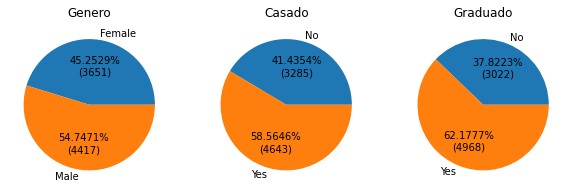

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(10, 5))

dfp = df[df.Gender.notnull()]
ax[0].set_title('Genero')
ax[0].pie(dfp.groupby(['Gender']).size(), autopct=my_fmt,labels=['Female','Male'])

dfp = df[df.Ever_Married.notnull()]
ax[1].set_title('Casado')
ax[1].pie(dfp.groupby(['Ever_Married']).size(),autopct=my_fmt,labels=['No','Yes'])

dfp = df[df.Graduated.notnull()]
ax[2].set_title('Graduado')
ax[2].pie(dfp.groupby(['Graduated']).size(),autopct=my_fmt,labels=['No','Yes'])

plt.show()

Como podemos observar en la grafica de abajo, las 3 profesiones mas populares son: en primer lugar artista con un 31%, seguido de healthcare con casi 17% y por ultimo entretenimiento con 12%. 

Text(0, 0.5, '')

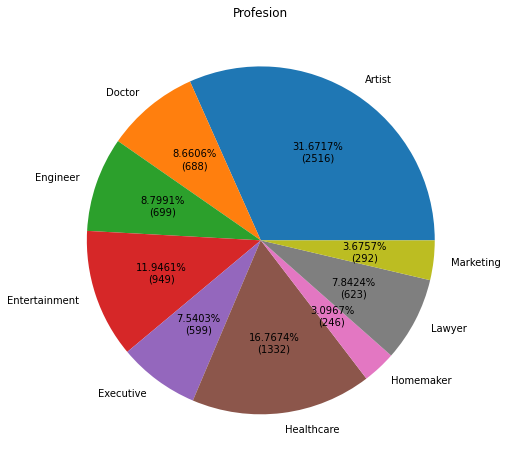

In [ ]:
dfp = df[df.Profession.notnull()]
dfp.groupby(['Profession']).size().plot.pie(autopct=my_fmt,figsize=(8,8))
plt.title('Profesion')
plt.ylabel('')

Con esta siguiente grafica observamos que la mayoria de personas tiene un puntaje gasto bajo, 24% son nivel medio y el 15% alto.

Text(0, 0.5, '')

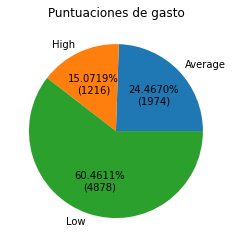

In [ ]:
dfp = df[df.Spending_Score.notnull()]
dfp.groupby(['Spending_Score']).size().plot.pie(autopct=my_fmt,figsize=(4,4))
plt.title('Puntuaciones de gasto')
plt.ylabel('')

Los histogramas de abajo nos dicen lo siguiente: 


*   Hay mas clientes entre las edades de 25 y 50, de 60 en adelante pocos.
*   Mas de la mitad de las personas tienen un rango de experiencia de trabajo de 0 a 15 años solamente.

*   La distribucion de los datos muestra que el tamaño de las familias primero sube y despues va bajando lentamente.





array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e8760b0d0>,
      dtype=object)

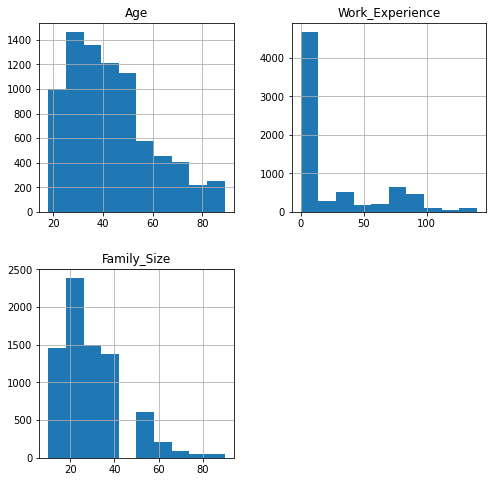

In [ ]:
df.loc[:, df.columns != 'ID'].hist(figsize=(8,8))

#Preparacion de datos

Aqui aplicamos las transformaciones a las variables categóricas. Hombres seran representados con 1 y mujeres con 0. Yes sera representado con 1 y No con 0. De acuerdo a la siguiente lista: ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing'], las profesiones seran enumeradas, del 0 al 8. Y por ultimo, Low, Average, High seran 0, 1, 2 en ese orden. 

In [ ]:
df['Gender'].replace(['Male', 'Female'], [1, 0], inplace=True)
df['Ever_Married'].replace(['Yes', 'No'], [1, 0], inplace=True)
df['Graduated'].replace(['Yes', 'No'], [1, 0], inplace=True)
df['Profession'].replace(['Healthcare', 'Engineer', 'Lawyer', 
                          'Entertainment', 'Artist', 'Executive','Doctor', 
                          'Homemaker', 'Marketing'], [0,1,2,3,4,5,6,7,8], inplace=True)
df['Spending_Score'].replace(['Low', 'Average', 'High'], [0,1,2], inplace=True)

Podemos ahora analizar todos los datos con la funcion describe.

In [ ]:
df.describe()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
count,8068.000000,8068.000000,7928.000000,8068.000000,7990.000000,7944.000000,7239.000000,8068.000000,7733.000000
mean,463479.214551,0.547471,0.585646,43.466906,0.621777,3.277568,26.416632,0.546108,28.501229
std,2595.381232,0.497772,0.492641,16.711696,0.484974,2.162217,34.067630,0.741202,15.314133
min,458982.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,10.000000
25%,461240.750000,0.000000,0.000000,30.000000,0.000000,1.000000,0.000000,0.000000,20.000000
50%,463472.500000,1.000000,1.000000,40.000000,1.000000,4.000000,10.000000,0.000000,30.000000
75%,465744.250000,1.000000,1.000000,53.000000,1.000000,4.000000,40.000000,1.000000,40.000000
max,467974.000000,1.000000,1.000000,89.000000,1.000000,8.000000,140.000000,2.000000,90.000000


Nos olvidamos de la columna ID, pues no aporta informacion importante para este ejercicio.

In [ ]:
sdf = df[["Gender", "Ever_Married",	"Age",	"Graduated",	"Profession",	"Work_Experience",	"Spending_Score",	"Family_Size"]]
sdf.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,1,0.0,22,0.0,0.0,10.0,0,40.0
1,0,1.0,38,1.0,1.0,NaN,1,30.0
2,0,1.0,67,1.0,1.0,10.0,0,10.0
3,1,1.0,67,1.0,2.0,0.0,2,20.0
4,0,1.0,40,1.0,3.0,NaN,2,60.0


Nos aseguramos que los tipos de datos son funcionales para las siguientes etapas.

In [ ]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   int64  
 1   Ever_Married     7928 non-null   float64
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   float64
 4   Profession       7944 non-null   float64
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   int64  
 7   Family_Size      7733 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 504.4 KB


**Datos Faltantes**

Observamos el porcentaje de observaciones faltantes por columna y decidimos eliminar en su totalidad la columna "Work_Experience", pues 10% de sus observaciones estan vacias y podrian afectar si intentamos corregirlos.

In [ ]:
sdf.isna().sum() * 100 / len(sdf)

Gender              0.000000
Ever_Married        1.735250
Age                 0.000000
Graduated           0.966782
Profession          1.536936
Work_Experience    10.275161
Spending_Score      0.000000
Family_Size         4.152206
dtype: float64

In [ ]:
sdf.drop('Work_Experience',axis=1,inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Para la variable Family_Size, podemos imputar la mediana a las observaciones faltantes.

In [ ]:
c_mediana = sdf.Family_Size.median()
sdf = sdf.fillna({'Family_Size': c_mediana})

Si revisamos las correlaciones de los datos, nos podemos dar cuenta de ciertos aspectos. Por ejemplo, la edad y el matrimonio son dos variables que se correlacionan, lo que nos quiere decir que las personas de mayor edad seguramente se habran casado y las personas jovenes no. 

In [ ]:
sdf.corr()

,Gender,Ever_Married,Age,Graduated,Profession,Spending_Score,Family_Size
Gender,1.000000,0.116135,0.030216,-0.034109,0.031822,0.061432,0.054059
Ever_Married,0.116135,1.000000,0.567130,0.196893,0.201160,0.616406,-0.078144
Age,0.030216,0.567130,1.000000,0.237309,0.130141,0.415485,-0.273373
Graduated,-0.034109,0.196893,0.237309,1.000000,0.160252,0.103468,-0.226733
Profession,0.031822,0.201160,0.130141,0.160252,1.000000,0.146313,-0.121153
Spending_Score,0.061432,0.616406,0.415485,0.103468,0.146313,1.000000,0.090888
Family_Size,0.054059,-0.078144,-0.273373,-0.226733,-0.121153,0.090888,1.000000


Por ello, a mi parecer, una buena tactica sería que a las personas menores de 35 les asignemos 0 de no haberse casado y viceversa para aquellos mayores de 35. El numero 35 lo decidi por cuenta propia observando la distribucion de los datos.

In [ ]:
mask = ((sdf.Ever_Married.isna()) & (sdf.Age < 35))
sdf = sdf.assign(Ever_Married=sdf.Ever_Married.mask(mask, other=0))
mask = ((sdf.Ever_Married.isna()) & (sdf.Age >= 35))
sdf = sdf.assign(Ever_Married=sdf.Ever_Married.mask(mask, other=1))

Lo mismo sucede con la variable "Graduated", por lo que hacemos lo mismo.

In [ ]:
mask = ((sdf.Graduated.isna()) & (sdf.Age < 35))
sdf = sdf.assign(Graduated=sdf.Graduated.mask(mask, other=0))
mask = ((sdf.Graduated.isna()) & (sdf.Age >= 35))
sdf = sdf.assign(Graduated=sdf.Graduated.mask(mask, other=1))

Por ultimo nos queda la variable "Profession", de acuerdo a las proporciones observadas en la grafica de arriba decido asignar valores de probalidad de salir de cada profesion. De este modo espero no alterar demasiado los resultados.

In [ ]:
l = [0,1,2,3,4,5,6,7,8]
p = [0.167, 0.09, 0.08, 0.12, 0.316, 0.075, 0.086, 0.03, 0.036]
sdf = sdf.fillna({'Profession': np.random.choice(l,p=p)})

Ahora, sin datos faltantes, los datos pueden ser lanzados al segmentador, pero antes debemos asegurarnos de que los datos esten a la misma escala para obtener mejores resultados.

In [ ]:
sdf.isna().sum() * 100 / len(sdf)

Gender            0.0
Ever_Married      0.0
Age               0.0
Graduated         0.0
Profession        0.0
Spending_Score    0.0
Family_Size       0.0
dtype: float64

#Estandarización

Como observamos la escala de algunos datos es muy diferente, por lo que debemos estandarizar. En este caso optare por solo estandarizar dos variables, "Age" y "Family_Size", porque las demas variables son categoricas y no le veo caso.

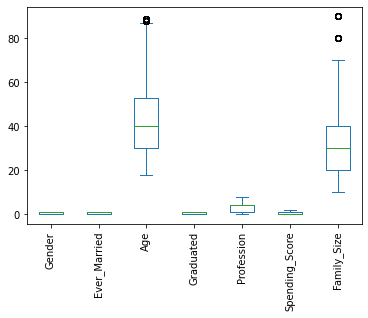

In [ ]:
sdf.plot.box(rot=90)

(array([1, 2, 3, 4, 5, 6, 7]), <a list of 7 Text major ticklabel objects>)

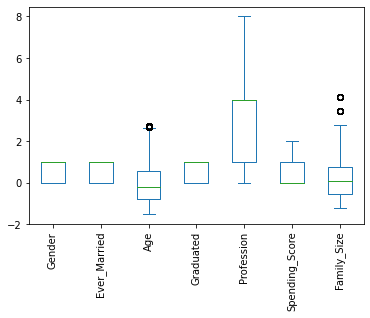

In [ ]:
scaler = StandardScaler()
sdf[['Age','Family_Size']] = scaler.fit_transform(sdf[['Age','Family_Size']])
sdf.plot.box()
plt.xticks(rotation=90)

**Datos atipicos**

En caso de que alguno de las variables estandarizadas tenga datos mayores a 3 desviaciones estandar entonces las eliminamos, eso sin antes asegurarnos de que no sean muchas observaciones. 

In [ ]:
outlier_data = sdf[["Age", "Family_Size"]].abs() > 3
any_outlier = outlier_data.any(axis=1) #¿existe algún valor atípico en la fila?
sum(any_outlier)/len(any_outlier)*100 #los outliers se distribuirán a los grupos con los que mayor similitud tengan

1.1650966782350025

(array([1, 2, 3, 4, 5, 6, 7]), <a list of 7 Text major ticklabel objects>)

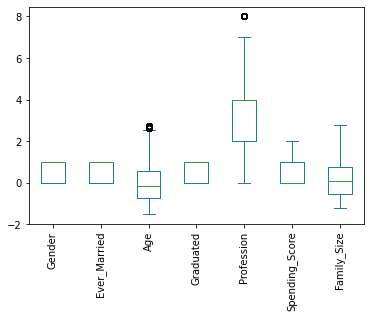

In [ ]:
sdf = sdf[~any_outlier.values]
sdf.plot.box()
plt.xticks(rotation=90)

Finalmente los datos estan listos para segmentar, al final nos quedamos con 7974 observaciones, lo cual me parece muy bien.

In [ ]:
len(sdf)

7974

#Agrupamiento

Encontramos el numero k de grupos optimo empleando el metodo del codo.

In [ ]:
whithin_var = []
for k in range(2,20):
  km = KMeans(n_clusters=k)
  km.fit(sdf)
  whithin_var.append(km.inertia_)

De acuerdo a la grafica, a mi criterio deberia ser 5 o 7, optare por 7.

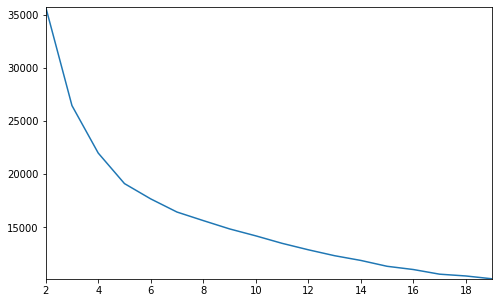

In [ ]:
plt.figure(figsize=(8,5))
plt.margins(x=0, y=0)
plt.plot(range(2,20), np.array(whithin_var))
plt.show()

#K-Medias

Una vez determinado el numero de k grupos más optimo, implementamos por fin el algoritmo de k-medias con nuestros datos limpios, transformados y estandarizados y con 7 el numero de clusters. 

In [ ]:
km = KMeans(n_clusters=7)
grupos = km.fit(sdf)

Asignamos a nuestra tabla de datos las etiquetas de los grupos y observamos la distribucion de estos. Como podemos observar, el grupo 3 es el mas habitado.

In [ ]:
sdf['Grupo'] = grupos.labels_
sdf.groupby('Grupo').size()

<ipython-input-174-3b40f815b525>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['Grupo'] = grupos.labels_


Grupo
0     782
1    1106
2    1155
3    1974
4    1034
5    1160
6     763
dtype: int64

#Invertir estandarizacion

Antes de analizar los resultados e intentar describir los perfiles, es importante regresar los datos a sus escalas originales, de otro modo sería complicado hacer una interpretacíon.

In [ ]:
sdf[['Age','Family_Size']] = scaler.inverse_transform(sdf[['Age','Family_Size']])
sdf.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,Gender,Ever_Married,Age,Graduated,Profession,Spending_Score,Family_Size,Grupo
0,1,0.0,22.0,0.0,0.0,0,40.0,5
1,0,1.0,38.0,1.0,1.0,1,30.0,0
2,0,1.0,67.0,1.0,1.0,0,10.0,6
3,1,1.0,67.0,1.0,2.0,2,20.0,6
4,0,1.0,40.0,1.0,3.0,2,60.0,1


#Perfilamiento

Con los datos ya de vuelta a su escala original, podemos ahora si analizar e interpretar los datos, para ello obtenemos la medio de los datos para cada variable de cada grupo.

In [ ]:
df_perf = sdf.groupby(['Grupo']).mean()
df_perf

,Gender,Ever_Married,Age,Graduated,Profession,Spending_Score,Family_Size
Grupo,,,,,,,
0,0.299233,0.567775,39.219949,0.636829,0.667519,0.423274,21.918159
1,0.658228,0.813743,42.109403,0.682640,3.843580,0.845389,43.074141
2,0.447619,0.413853,35.983550,0.516883,6.700433,0.303030,27.497835
3,0.562817,0.528875,41.626140,0.818642,3.757852,0.187943,18.115502
4,0.694391,0.997099,58.088975,0.763056,4.491296,1.454545,26.499033
5,0.554310,0.057759,25.501724,0.234483,0.116379,0.061207,41.008621
6,0.546527,0.952818,74.568807,0.606815,2.053735,1.044561,19.947575


Ademas, por grupo, obsrevamos la graficamos la frecuencia de las prefesiones para conocer mas.

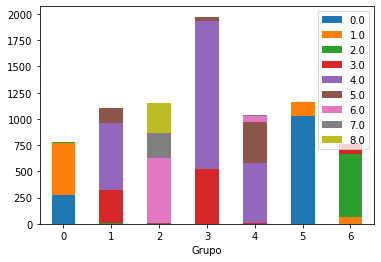

In [ ]:
s = sdf.groupby('Grupo')['Profession'].value_counts()
s.unstack().plot.bar(stacked=True, rot=0)
plt.legend(loc='upper right')

Healthcare-0, Engineer-1, Lawyer-2, Entertainment-3, Artist-4, Executive-5, Doctor-6, Homemaker-7, Marketing-8 

#Grupo 0

70% de los clientes son mujeres, casi mismo numero de personas que se han casado y nunca se han casado, la edad promedio es de 39 años, 63% de de las personas se han graduado y el tamaño promedio familiar es de 22. En su mayoria son ingenieros o estan en healthcare.

#Grupo 1

65% de los clientes son hombres, un poco más del 80% se han casado, la edad promedio es de 42 años, 68% de de las personas se han graduado y el tamaño promedio familiar es de 43. Son creativos, son mas artistas o de entretenimiento.

#Grupo 2

Es casi el mismo numero hombres y mujeres, un poco menos de la mitad se ha casado, la edad promedio es de 36 años, la mitad se ha graduado la otra mitad no, y el tamaño promedio familiar es de 27. Doctores o en marketing

#Grupo 3

Son casi la misma cantidad de hombres y mujeres, mismo numero de personas que se han casado y nunca se han casado, la edad promedio es de 41 años, 82% de de las personas se han graduado y el tamaño promedio familiar es de 18. Son creativos, son mas artistas o de entretenimiento.

#Grupo 4

70% de los clientes son hombres, casi en su totalidad son personas que se han casado, la edad promedio es de 58 años, 76% de de las personas se han graduado y el tamaño promedio familiar es de 26. Artistas o ejecutivos.

#Grupo 5

Son casi la misma cantidad de hombres y mujeres, la mayoria son personas no casadas, la edad promedio es de 25 años, 23% de de las personas se han graduado y el tamaño promedio familiar es de 41. En general trabajan mas en healthcare.

#Grupo 6

Hay un poco mas de hombres que mujeres, casi todos se han casado, la edad promedio es de 74 años, 60% de de las personas se han graduado y el tamaño promedio familiar es de 19. Son abogados.